In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Fri Aug  9 07:24:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCH = 30
CHANELS=3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Train",
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size =  BATCH_SIZE
)

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\asus\AppData\Local\Temp\ipykernel_13772\150634401.py:2: SyntaxWarning: invalid escape sequence '\S'
  "D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Train",


Found 2152 files belonging to 3 classes.


In [6]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch)

(32, 256, 256, 3)
tf.Tensor([1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 2 0 2], shape=(32,), dtype=int32)


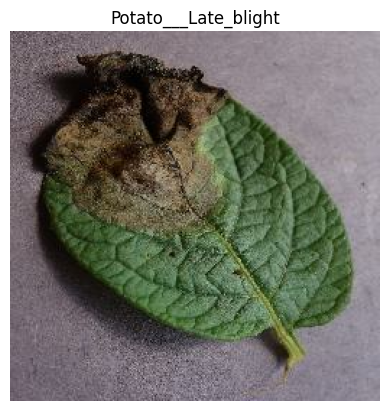

In [9]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("float32")/255.0)
    plt.title(classes[label_batch[0]])
    plt.axis("off")

In [10]:
TRAIN_SIZE = int(len(dataset)*0.8)
VAL_SIZE = int(len(dataset)*0.1)
print(TRAIN_SIZE,VAL_SIZE)

54 6


In [11]:
def train_test_split(
    dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):

  #Initializing Dataset Size
  dataset_size = len(dataset)

  #Shuffeling the Dataset
  if shuffle:
    dataset = dataset.shuffle(shuffle_size,seed=12)

  #Creating train,test,val size
  train_size = int(dataset_size*train_split)
  test_size = int(dataset_size*test_split)
  val_size = int(dataset_size*val_split)

  #Creating TRAIN,TEST and VALIDTION dataset
  train_ds = dataset.take(train_size)
  val_ds = (dataset.skip(train_size)).take(val_size)
  test_ds = (dataset.skip(train_size)).skip(test_size)

  return train_ds, test_ds, val_ds

In [12]:
train_ds, test_ds, val_ds = train_test_split(dataset)

In [13]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

54
8
6


In [14]:
#Optimizing the Dataset for Training

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [17]:
input_shape = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANELS)
n_classes = 3

In [18]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape = input_shape)

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
  model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
hist = model.fit(
    train_ds,
    epochs= EPOCH,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.4857 - loss: 0.9311 - val_accuracy: 0.6302 - val_loss: 0.8155
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6292 - loss: 0.7425 - val_accuracy: 0.7865 - val_loss: 0.4171
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7537 - loss: 0.5416 - val_accuracy: 0.8542 - val_loss: 0.3792
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8310 - loss: 0.4049 - val_accuracy: 0.8854 - val_loss: 0.3080
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8738 - loss: 0.3208 - val_accuracy: 0.9115 - val_loss: 0.2663
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8984 - loss: 0.2722 - val_accuracy: 0.8750 - val_loss: 0.3156
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8631 - loss: 0.3248 - val_accuracy: 0.8958 - val_loss: 0.2716
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8768 - loss: 0.3308 - val_accuracy: 0.9323 - val_loss

In [22]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 489ms/step - accuracy: 0.9657 - loss: 0.1156


In [23]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Actual Class: Potato___Early_blight
Predicted Class: Potato___Early_blight


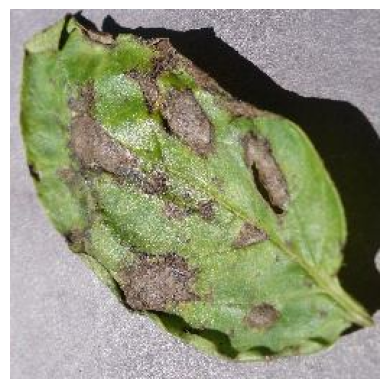

In [24]:
for image_batch,label_batch in dataset.take(1):

  first_image = (image_batch[0].numpy().astype("float32")/255.0)
  first_label = classes[label_batch[0]]

  batch_prediction = model.predict(image_batch)

  print("Actual Class:",first_label)



  # print(batch_prediction[0])
  # print(np.argmax(batch_prediction[0]))

  print("Predicted Class:",classes[np.argmax(batch_prediction[0])])

  plt.imshow(first_image)
  plt.axis("off")

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


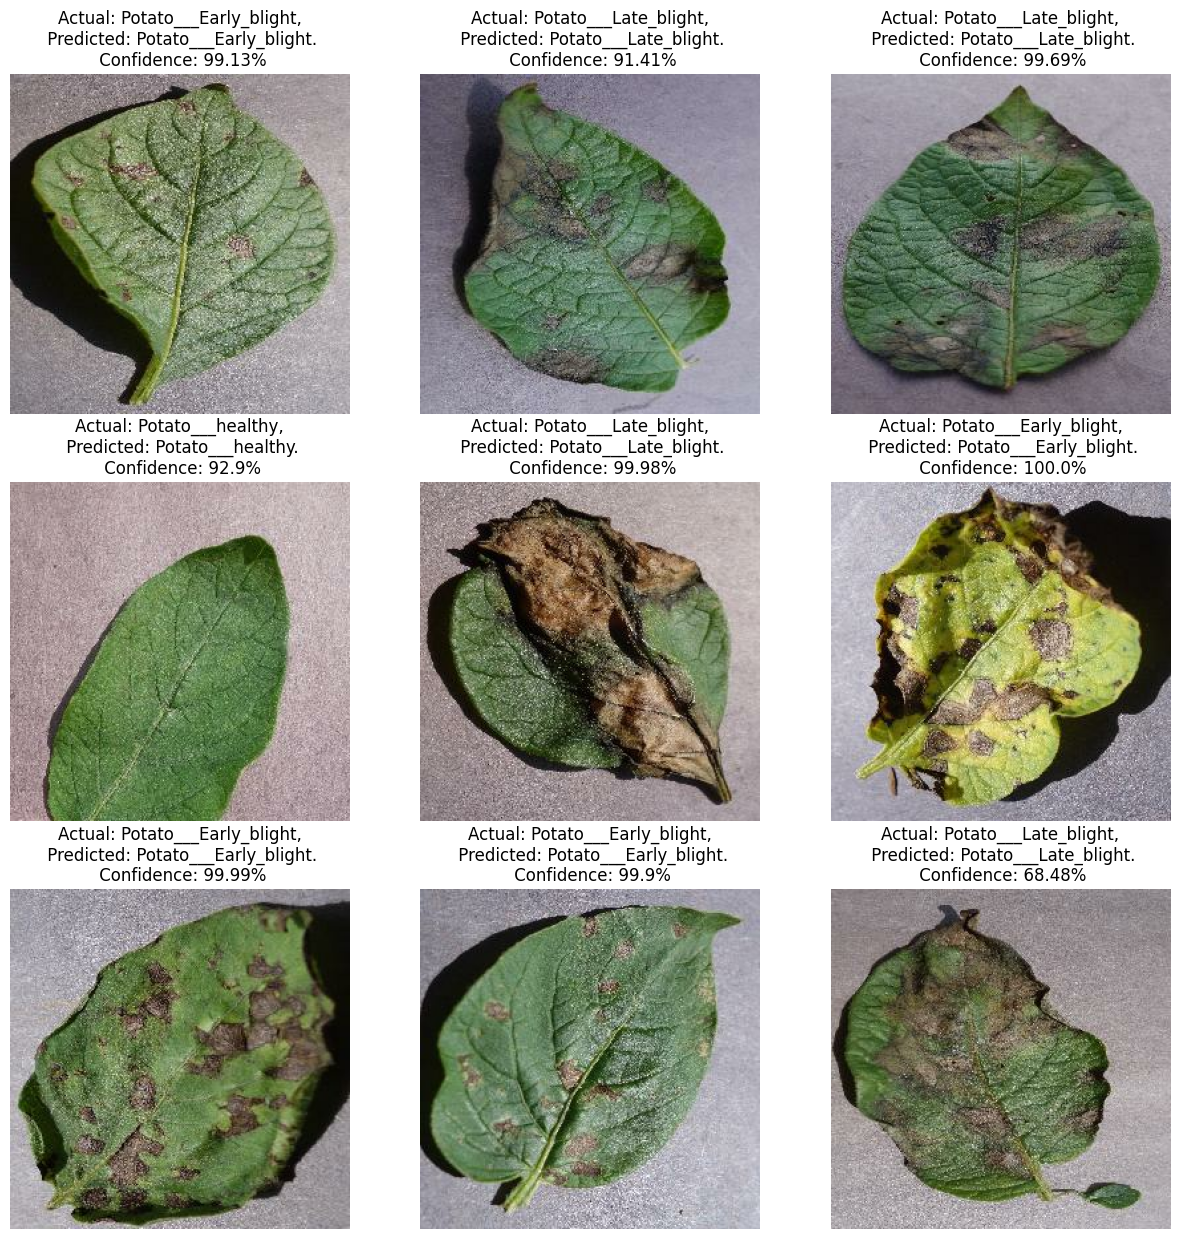

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:
model_version=2
model.export(
    f"D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Models\{model_version}"
    )

<string>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\S'
<string>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\S'
C:\Users\asus\AppData\Local\Temp\ipykernel_13772\659123443.py:3: SyntaxWarning: invalid escape sequence '\{'
  f"D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Models\{model_version}"
C:\Users\asus\AppData\Local\Temp\ipykernel_13772\659123443.py:3: SyntaxWarning: invalid escape sequence '\S'
  f"D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Models\{model_version}"


INFO:tensorflow:Assets written to: D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Models\2\assets


INFO:tensorflow:Assets written to: D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Models\2\assets


Saved artifact at 'D:\Soumyadeep Das\CODING\Potato_Leaf_Desease\Potato\Models\2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2318485064592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485064784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485067280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485068624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485068816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485069584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485069200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485069968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485069008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318485070352: TensorSpec(shape=(), dtype=tf.resource, nam